# Kernel CSDA

Siguendo a Potworosky et al, vamos a implementar el kCSDA aquí y tratar de hacer que funcione bien.


### Problema 1 a) Calcular $b_j (x_k)$

Usa tu cabeza chico: en realidad sólo necesitas una TABLOTA de los valores de la integral resuelta, de forma que cubra toda la matriz para cualquier $x_k$ válido que escogas, lo que haría que *"solo"* tuvieras que resolver los valores para una malla de $129·129$ puntos o algo asi: pero tienes simetría rotacional respecto al centro $j$-
ésimo, así que en realidad puedes reducir esto bastante: calculemos esto en una rebanada de un octavo de cuadrado (un cuadrante de la matriz reducido a la mitad). Para "ahorrarme" trabajo después copiare los resultados en todos los octantes y guardare la tabla como una matrizota.

In [44]:
#Constantes
#Las unidades de distancia estan en unidades de distancia inter electrodos:  
#1 u.a.=42 µm
sigma=1.0
h=8+1/3  #350/42
radio=15.0 

15.0

Pero antes... quiero ver como se VE la función que voy a integrar.

In [7]:
using PyPlot

In [45]:
function duro(x::Number)
    if abs(x)<radio
        return 1.0
    else
        return 0
    end
end


function suave(x::Number)
    result=exp(-x^2/(2*radio))
    return result
end

function bkerneldura(x::Number)
    xcero=1
        result=asinh(h/sqrt((x-xcero)^2))*duro(x,radio)
    return result
end

function bkernelsuave(x::Number)
    xcero=1
    result=asinh(h/sqrt((x-xcero)^2))*suave(x,radio)
    return result
end



bkernelsuave (generic function with 1 method)

In [46]:
xxs=0:0.02:5
yys=map(bkerneldura,xxs);
otrayys=map(bkernelsuave,xxs);

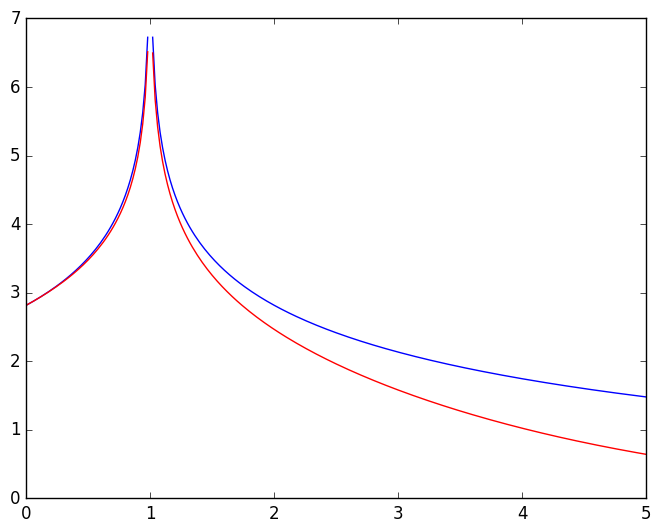

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ef0a19cc0>

In [47]:
plot(xxs,yys,c="blue")
plot(xxs,otrayys,c="red")


Bien. Parece que los dos se parecen mucho cerca de la singularidad, y que no hay nada que ver después de 2 distancias de R, en la imagen de arriba tenemos que R=2, xcero=1, h=1. 

In [48]:
function distancia2d(x1::Number,y1::Number,x2::Number,y2::Number)
    result=sqrt((x1-x2)^2+(y1-y2)^2)
    return result
end

function distancia2d(x1::Array,x2::Array)
    result=distancia2d(x1[1],x1[2],x2[1],x2[2])
    return result
end

distancia2d (generic function with 2 methods)

In [49]:
a=[1.0,2.0]

b=[0.0,0.0]

2-element Array{Float64,1}:
 0.0
 0.0

In [50]:
distancia2d(0.1,2,0.7,0.1)

1.9924858845171274

In [51]:
distancia2d(a,b)

2.23606797749979

In [73]:
function duro2D(x1::Number,y1::Number)
    if distancia2d(x1,y1,0,0)<=radio
        return 1.0
    else
        return 0
    end
end
    
function suave2D(x1::Number,y1::Number)
    result=exp(-distancia2d(x1,y1,0,0)/(2*radio))
    return result
end
   

function bKernelDuro2D(x1::Number,y1::Number, x2::Number,y2::Number)
    #=
    Acuerdate: Estos estan centrados en el origen, despues los vamos trasla<dando 
    sea necesario 
    =#
    dist=distancia2d(x1,y1,x2,y2)
    result=asinh(h/dist)*duro2D(x2,y2)
    return result
end

function bKernelSuave2D(x1::Number,y1::Number, x2::Number,y2::Number)
    #=
    Acuerdate: Estos estan centrados en el origen, despues los vamos trasla<dando 
    sea necesario 
    =#
    dist=distancia2d(x1,y1,x2,y2)
    result=asinh(h/dist)*suave2D(x2,y2)
    return result
end


bKernelSuave2D (generic function with 1 method)

In [53]:
xefecto=[1.0,0.50]
xobservador=[3.0,5.0]

2-element Array{Float64,1}:
 3.0
 5.0

In [54]:
xxs=-63:63
yys=-63:63

-63:63

In [74]:
matrizevaluacionobservadores=zeros(127,127);
matrizevaluacioncausantesres=zeros(127,127);
for j in 1:127, k in 1:127
    zz1=bKernelSuave2D(xxs[j],yys[k], xefecto[1],xefecto[2])
    matrizevaluacionobservadores[k,j]=zz1
    zz2=bKernelSuave2D(xobservador[1],xobservador[2],xxs[j],yys[k])
        matrizevaluacioncausantesres[k,j]=zz2    
end

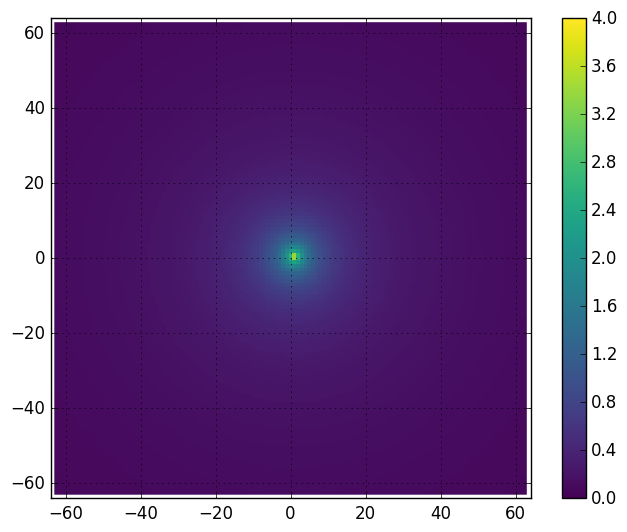

PyObject <matplotlib.colorbar.Colorbar object at 0x7f8ef02c7668>

In [75]:
xlim(-64,64)
ylim(-64,64)
zlimitemax=4
zlimitemin=0
grid(true)
figuru=imshow(matrizevaluacionobservadores, origin="lower",extent=[-63,63,-63,63], 
interpolation="none", cmap="viridis",vmin=zlimitemin, vmax=zlimitemax)
cb=colorbar(figuru)

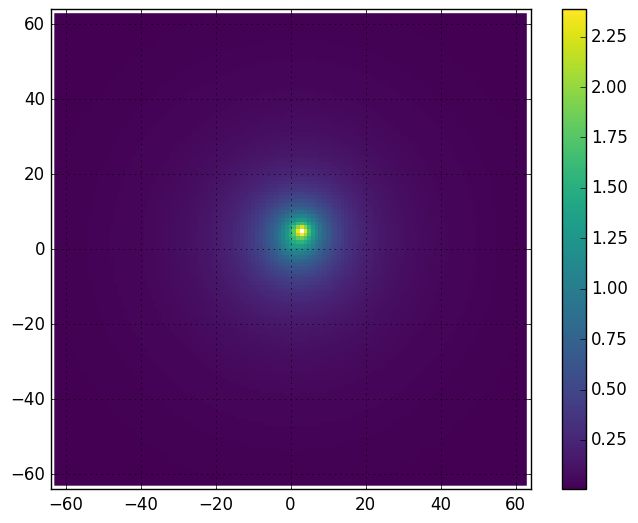

PyObject <matplotlib.colorbar.Colorbar object at 0x7f8ef0065710>

In [76]:
xlim(-64,64)
ylim(-64,64)
zlimitemax=4
zlimitemin=0
grid(true)
figuru=imshow(matrizevaluacioncausantesres, origin="lower",extent=[-63,63,-63,63], 
interpolation="none", cmap="viridis")
cb=colorbar(figuru)

In [82]:
matrizevaluacioncausantesres[1,1]

0.004506440159786894

Bueno, hasta aquí parece que vamos bien: Ahora fijamos las $x$ del Observador e integremos la chiva respecto a las fuentes.

In [77]:
using Cubature

INFO: Precompiling module Cubature...


In [ ]:
hcubature(x ->
    bKernelDuro2D(xobservador[1],xobservador[2], x[1],x[2]),
     [-65,-65],[65,65])

In [ ]:
(chula,errir)=hcubature(x ->
    bKernelDuro2D(xobservador[1],xobservador[2], x[1],x[2]),
     [-200,-200],[200,200])

In [102]:
chula*4

5.037130074075731